In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# import data from previous wrangle and EDA notebooks
df_houses = pd.read_csv('houses.csv')
test = pd.read_csv('houses_test.csv')

In [3]:
df_houses

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,0,8,2007,WD,Normal,175000
1455,1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,...,0,0,4,NaN,0,2,2010,WD,Normal,210000
1456,1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,...,0,0,5,Shed,2500,5,2010,WD,Normal,266500
1457,1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,0,4,2010,WD,Normal,142125


In [4]:
df_houses.drop(columns =['Unnamed: 0','Id'], inplace=True)
Id = test['Id']
test.drop(columns =['Unnamed: 0', 'Id'], inplace=True)

In [5]:
#split numeric features
df_houses_numeric = df_houses.select_dtypes([np.number])
df_test_numeric = test.select_dtypes([np.number])
df_houses_numeric = df_houses_numeric.drop(columns=['SalePrice'])
houses_num_col = df_houses_numeric.columns

In [6]:
df_houses_numeric.shape

(1459, 51)

In [7]:
df_houses_numeric.isna().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Fireplaces       0
FireplaceQu      0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC           0
Fence            0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [8]:
# examin outliers

q5, q95 = df_houses_numeric.quantile(.005, axis=0), df_houses_numeric.quantile(.995, axis=0)
iqr = q95 - q5


In [9]:
# save outliers to be removed later
drop_out = df_houses_numeric[(df_houses_numeric > (q95 + iqr * 1.5)).any(axis=1)]

drop_out.shape


(12, 51)

In [10]:
# scale numeric features

from sklearn.preprocessing import RobustScaler  
scaler = RobustScaler ()

df_houses_numeric = scaler.fit_transform(df_houses_numeric)

# test is transform only
df_test_numeric = scaler.transform(df_test_numeric)

In [11]:
#replacing numeric features with scaled versions

df_houses_numeric = pd.DataFrame(df_houses_numeric, columns=houses_num_col)
df_houses[houses_num_col] = df_houses_numeric

In [12]:
#drop outliers from train only

df_houses.drop(drop_out.index, inplace=True)

In [13]:
#replacing numeric features in test with scaled versions

df_test_numeric = pd.DataFrame(df_test_numeric, columns=houses_num_col)
test[houses_num_col] = df_test_numeric

In [14]:
# make dummies for catagorical features
df_train = pd.get_dummies(df_houses)
df_test = pd.get_dummies(test)

In [15]:

dif_test = df_train.columns.difference(df_test.columns).values

# not all dummie features in both sets. We'll fill with 0s to match shapes
df_test[dif_test] = 0

In [16]:
dif_train = df_test.columns.difference(df_train.columns).values
df_train[dif_train] = 0

In [17]:
#remove sales price column from test it got added on with the numeric values
df_test= df_test.drop(columns=['SalePrice'])

In [18]:
#double check the dataframe
df_houses.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [19]:
df_train.shape

(1447, 234)

In [20]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MiscFeature_Gar2
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,...,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.0
mean,0.135936,0.258429,0.153375,0.046994,0.574292,-0.037980,-0.247408,0.625963,0.395301,0.082239,...,0.083621,0.002073,0.867312,0.068417,0.002764,0.007602,0.013822,0.821700,0.085695,0.0
std,0.845741,1.109175,1.508585,0.689681,1.113156,0.657909,0.558992,1.095251,0.573678,0.350078,...,0.276915,0.045502,0.339355,0.252548,0.052522,0.086887,0.116791,0.382897,0.280009,0.0
min,-0.600000,-2.210526,-2.017020,-2.500000,-4.000000,-2.195652,-1.189189,0.000000,-1.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,-0.600000,-0.157895,-0.487667,-0.500000,0.000000,-0.413043,-0.729730,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,0.000000,0.000000,-0.009373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,0.400000,0.842105,0.500493,0.500000,1.000000,0.597826,0.270270,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,2.800000,13.157895,26.066108,2.000000,4.000000,0.804348,0.432432,9.726444,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [21]:
df_test.shape

(1459, 233)

In [22]:
# split into train and test
X = df_train.drop("SalePrice", axis = 1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=648)

In [23]:
#start with a basic regression


model1 = LinearRegression()

model1.fit(X_train, y_train)

print('cv_score', np.mean(cross_val_score(model1, X_train, y_train, cv=5)))

y_pred = model1.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R2 score:', r2_score(y_test, y_pred))

cv_score -236589349952396.34
MAE: 196540503358.67316
MSE: 2.920348278254232e+24
RMSE: 1708902653241.03
R2 score: -532549051070065.5


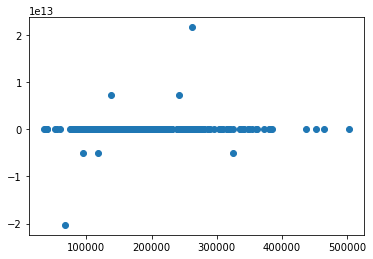

In [24]:
#check out the odd results
plt.scatter(y_test, y_pred)

The regular model is predicting a negative price throwing the whole model off. We'll try a veriety of other models.

In [25]:
y_dif = np.abs(y_test-y_pred )
y_dif.sort_values(ascending=False)[0:10]

1187    2.166245e+13
398     2.027613e+13
271     7.200002e+12
1275    7.199997e+12
1186    4.936546e+12
9       4.936546e+12
583     4.935985e+12
1324    1.571498e+05
681     8.334197e+04
1000    8.194300e+04
Name: SalePrice, dtype: float64

In [26]:
#import models we'd like to try

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import warnings
#warnings.filterwarnings("ignore", category=[ConvergenceWarning, RuntimeWarning])
warnings.filterwarnings("ignore")

from sklearn.exceptions import ConvergenceWarning

In [27]:
#define a function to use random search to find best paramiters

from sklearn.model_selection import RandomizedSearchCV

def find_best_param(model, param_grid):
        model_cv = RandomizedSearchCV(model, param_grid, cv=5, random_state=648)
        model_cv.fit(X_train, y_train)
        return model_cv.best_estimator_



In [28]:



#define empty dicts for what we might want to access later

model_scores ={}
y_preds = {}
params_used ={}

# define funtion that calls our find_best_params function to initiate new model 
# and save our model_scores, y_preds, and params_used for each model that we try

#@ignore_warnings(category=[ConvergenceWarning, RuntimeWarning])
def scoring(model_name, model, param_grid):
    
    
    
    new_model = find_best_param(model, param_grid)
    new_model.fit(X_train, y_train)

    y_pred = new_model.predict(X_test)
    
   
    params_used[model_name] = new_model
    y_preds[model_name] = y_pred
    
    model_scores[model_name] = {'model used': model,
                                'cv_score': np.round(np.mean(cross_val_score(new_model, X_train, y_train, cv=5)), 2),
                                'MAE': np.round(mean_absolute_error(y_test, y_pred), 2),
                                'MSE': np.round(mean_squared_error(y_test, y_pred), 2),
                                'RMSE': np.round(mean_squared_error(y_test, y_pred, squared=False), 2),
                                'R2 score': np.round(r2_score(y_test, y_pred), 2)
                               }
    model_scores, y_preds, params_used

In [29]:
#test the find_best_params function

find_best_param(Ridge(), {'alpha': np.arange(0.001, 300)})

Ridge(alpha=23.000999999999998)

In [30]:
#define params and run Ridge model

alpha_params = {'alpha': np.arange(0.001, 200)}

scoring('model2', Ridge(random_state=648), alpha_params)

In [31]:
# useing same params run Lasso

scoring('model3', Lasso(random_state=648), alpha_params);

In [32]:
# useing same params run ElasticNet

scoring('model4', ElasticNet(random_state=648), alpha_params)

In [33]:
RFR_params = {'n_estimators': [300, 500, 800, 1000],
              'max_features': ['auto', 'log2'],
              'max_depth': [10, 20, 30, 40, 50, None],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 2, 5, 10, 15]
             }

scoring('model5', RandomForestRegressor(random_state=648), RFR_params)

In [34]:
# define params and run DecisionTree

DTR_params = {'max_depth': np.arange(1, 20),
              'min_samples_split': range(10, 60)}


scoring('model6', DecisionTreeRegressor(random_state=648), DTR_params)

In [35]:
# define params and run GradientBoost

GBR_params = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100],
              'n_estimators': [ 50, 250, 500, 750, 1000],
              'max_features': ['auto', 'log2'],
              'max_depth': [1, 3, 5, 7, 10, 25, 50],
              'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
              'min_samples_leaf': [1, 2, 5, 10, 15, 20, 25]
             }


scoring('model7', GradientBoostingRegressor(random_state=648), GBR_params);

In [36]:
# define params and run SVR

SVR_params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              }

scoring('model8', SVR(), SVR_params)

In [37]:
# time to check out some scores

scores = pd.DataFrame(model_scores).T

scores

,model used,cv_score,MAE,MSE,RMSE,R2 score
model2,Ridge(random_state=648),0.85,17032.66,534966574.19,23129.34,0.9
model3,Lasso(random_state=648),0.85,16647.16,504281429.22,22456.21,0.91
model4,ElasticNet(random_state=648),0.56,35602.97,2352584195.91,48503.45,0.57
model5,RandomForestRegressor(random_state=648),0.86,16180.45,561752316.55,23701.31,0.9
model6,DecisionTreeRegressor(random_state=648),0.76,24056.88,1074308871.56,32776.65,0.8
model7,GradientBoostingRegressor(random_state=648),0.87,15320.07,542655456.02,23294.97,0.9
model8,SVR(),-0.01,52191.87,5301076305.15,72808.49,0.03


Model 7 GradientBoost is slightly better then Lasso. Lets see if we can explore what is going on

In [ ]:
#what values paramiters did we end up with?
#params_used

The GradientBoost is not predicting the extreams of the test set. The STD is off by about 7500 and our mean is off by almost 1500

In [ ]:
# a quick visual
plt.scatter(y_test, y_preds['model7'])

In [ ]:
#check highest residuals
y_dif = np.abs(y_test-y_preds['model7'] )
y_dif.sort_values(ascending=False)[:10]

In [ ]:
y_dif.describe()

Clearly some high redisuals for the higher priced houses. The mean residual is almost 1,500 and std is close to 19,000 Lets see the model on the train scores.

In [ ]:
model7_train = params_used['model7']

model7_train.fit(X_train, y_train)
y_pred_train = model7_train.predict(X_train)

print('cv_score:', np.mean(cross_val_score(model7_train, X_train, y_train, cv=5)),
      'MAE:', mean_absolute_error(y_train, y_pred_train),
      'MSE:', mean_squared_error(y_train, y_pred_train),
      'RMSE:', mean_squared_error(y_train, y_pred_train, squared=False),
      'R2 score:', r2_score(y_train, y_pred_train))

The Gradient booster model is a little over fit on the train set. 
Lets see if we can fine tune the paramiters further and also try more gradient boosting options.

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as XGB
from catboost import CatBoostRegressor
import lightgbm as LGB

In [ ]:
params_used['model7']

In [ ]:
#gridsearch area picked by randomsearch
param_grid = {'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
              'max_depth': np.arange(7, 13),
              'max_features': ['log2'],
              'min_samples_leaf': np.arange(17, 23),
              'min_samples_split':np.arange(17, 23),
              'n_estimators': [ 650, 700, 750, 800, 850]}

model7_gs = GradientBoostingRegressor(random_state=35)
model7_gscv = GridSearchCV(model7_gs, param_grid, cv=5)
model7_gscv.fit(X_train, y_train)

model7_gscv.best_estimator_

In [ ]:
model9 = model7_gscv.best_estimator_
model9.fit(X_train, y_train)

y_pred = model9.predict(X_test)

y_preds[model9] = y_pred
    
model_scores[model9] = {'model used': GradientBoostingRegressor(),
                            'cv_score': np.mean(cross_val_score(model9, X_train, y_train, cv=5)),
                            'MAE': mean_absolute_error(y_test, y_pred),
                            'MSE': mean_squared_error(y_test, y_pred),
                            'RMSE': mean_squared_error(y_test, y_pred, squared=False),
                            'R2 score': r2_score(y_test, y_pred)
                            }
model_scores[model9]

In [ ]:
model9_pred = model9.predict(df_test)

pred = pd.DataFrame(model9_pred)
submission1 = pd.concat([Id, pred], axis=1)
submission1.columns = ['Id','SalePrice']
submission1

In [ ]:
#submission1.to_csv('submission1.csv', index =False)
# kaggle competition recieves a score of 0.16373
# number 9133 on the leaderboard at time of submition

In [ ]:
model10 = XGB.XGBRegressor(random_state=35)
model10.fit(X_train, y_train)

In [ ]:
# define params and test xgboost

#XG_params = {
#    'max_depth': range(3,15),
#    'min_child_weight': range(1,12),
#    'learning_rate': [0.01, 0.05, 0.1, 0.3],
#    'subsample': range(1,15),
#    'colsample_bytree': range(1,15),
#    'objective':['reg:linear'],
#    }

from scipy.stats import uniform, randint
XB_params = {
    "colsample_bytree": uniform(0.3, 0.7),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "subsample": uniform(0.4, 0.6)
}

#scoring('model10', XGB.XGBRegressor(), XG_params)

model10 = XGB.XGBRegressor(random_state=35)
model10_gscv = RandomizedSearchCV(model10, XG_params, n_iter=100, n_jobs=1, cv=3)
#model10_gscv.fit(X_train, y_train)
#y_pred = model11.predict(X_test)
#mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
model11_lbg = LGB.LGBMRegressor(random_state=35)
model11_lbg.fit(X_train, y_train)
y_pred = model11_lbg.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
model11_lbg

In [ ]:
# try LGBM


LBG_params = {
    'num_leaves': [5, 10, 25, 40, 55, 70, 85],
    'min_child_samples': [50, 75, 100, 125],
    'min_split_gain': [0.0, 0.001, 0.01],
    'num_iterations': [50, 75, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
}

#model11_gs = LGB.LGBMRegressor()
#model11_gscv = RandomizedSearchCV(model11_gs, LBG_params, cv=3)
#model11_gscv.fit(X_train, y_train)

scoring('model11', LGB.LGBMRegressor(random_state=35), LBG_params)

In [ ]:
model_scores['model11']

In [ ]:
 # try CatBoostRegressor
cat_params = {'iterations': [10, 25, 50],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'depth':[ 10, 20, 30]}
    
scoring('model12', CatBoostRegressor(random_state=35), cat_params)

In [ ]:
model_scores['model12']

In [ ]:
scores = pd.DataFrame(model_scores).T
scores

In [ ]:
model-_pred = model-.predict(df_test)

pred = pd.DataFrame(model-_pred)
submission = pd.concat([Id, pred], axis=1)
submission.columns = ['Id','SalePrice']
submission